In [246]:
import pybamm
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt

In [247]:
# File path
path = r"C:\UM\Project\PyBaMM\src\pybamm\Diffusion_Fit\PulseTest\TVS_21700_HybridPulse_40Deg\trial_data"
file = "One_pulse_05.csv"
file_path = os.path.join(path, file)


# Load CSV file directly
def load_data(file_path):
    data = pd.read_csv(file_path, skiprows=1).to_numpy()

    # Extract time, current, and voltage columns
    time = data[:, 0]  # Assuming first column is time
    current = data[:, 1]  # Assuming second column is current
    voltage = data[:, 2]  # Assuming third column is voltage
    initial_voltage = voltage[0]
    # Create PyBaMM interpolants
    current_interp = pybamm.Interpolant(time, current, pybamm.t)
    voltage_interp = pybamm.Interpolant(time, voltage, pybamm.t)

    initial_voltage = voltage[0]  # Set initial voltage
    return time, current, current_interp, voltage, voltage_interp, initial_voltage

In [248]:
def get_init_conc():
    time, current, current_interp, voltage, voltage_interp, initial_voltage = load_data(
        file_path
    )
    experiment = pybamm.Experiment(
        [
            f"Charge at 0.1 A until {initial_voltage} V",
            f"Hold at {initial_voltage} V until 0.1 mA",
        ]
    )
    model = pybamm.lithium_ion.SPM()
    param = model.default_parameter_values
    sim_cccv = pybamm.Simulation(model, experiment=experiment)
    sol_cccv = sim_cccv.solve()
    # model.variables.search("Positive particle concentration")
    Negative_init_conc = sol_cccv["Average negative particle concentration [mol.m-3]"]
    Positive_init_conc = sol_cccv["Average positive particle concentration [mol.m-3]"]
    print(initial_voltage)
    return Negative_init_conc.data[-1], Positive_init_conc.data[-1]


a, b = get_init_conc()
print(a)
print(b)

4.098
23671.924342803002
26308.377741291235


In [283]:
# Define PyBaMM DFN model
def create_SPM_model(initial_voltage):
    model = pybamm.lithium_ion.SPM()
    param = model.default_parameter_values

    # Estimate initial SOC
    c_n_init, c_p_init = get_init_conc()
    # Update parameters with initial concentrations
    param.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": c_n_init,
            "Initial concentration in positive electrode [mol.m-3]": c_p_init,
        }
    )
    """
    experiment = pybamm.Experiment(
    [
        "Rest for 1 hour",
        "Discharge at C/30 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour",
    ])
    simu = pybamm.Simulation(model, experiment=experiment, parameter_values=param)
    simu.solve()
    simu.plot([
        "Voltage [V]",'Average positive particle concentration [mol.m-3]',])
    """
    return model, param


time, current, current_interp, voltage, voltage_interp, initial_voltage = load_data(
    file_path
)
print(current_interp)
model, param = create_dfn_model(4.1)
param["Current function [A]"] = current_interp
sim = pybamm.Simulation(model, parameter_values=param)
sim.solve(time)
sim.plot(
    [
        "Voltage [V]",
        "Average positive particle concentration [mol.m-3]",
        "Current [A]",
    ]
)

ing_functio(time)
4.098


interactive(children=(FloatSlider(value=0.4, description='t', max=394.90803349543256, min=0.4, step=3.94908033…

In [250]:
iteration_counter = 0


def cost_function(params, time, current, voltage, model, param):
    # Update parameters (positive and negative electrode diffusivities)
    param.update(
        {
            "Negative electrode diffusivity [m2.s-1]": params[0],
            "Positive electrode diffusivity [m2.s-1]": params[1],
        }
    )
    # Solve model with given parameters
    sim = pybamm.Simulation(model, parameter_values=param)
    sim.solve(time, inputs={"Current function [A]": current})

    # Extract simulated voltage
    sim_time = sim.solution["Time [s]"].entries
    sim_voltage = sim.solution["Terminal voltage [V]"].entries
    # Interpolate simulated voltage to match experimental time points
    interpolated_voltage = np.interp(time, sim_time, sim_voltage)

    # Compute error (RMSE)
    error = np.sqrt(np.mean((interpolated_voltage - voltage) ** 2))
    global iteration_counter
    iteration_counter += 1
    print(f"Iteration {iteration_counter}: Parameters: {params}, RMSE: {error}")
    return error

In [251]:
# Optimization routine
def optimize_diffusivity(file_path):
    time, current, current_interp, voltage, voltage_interp, initial_voltage = load_data(
        file_path
    )
    model, param = create_dfn_model(initial_voltage)

    # Initial guess for diffusivities
    initial_guess = [1e-14, 1e-14]  # Adjust if needed

    # Run optimization
    result = minimize(
        cost_function,
        initial_guess,
        args=(time, current, voltage, model, param),
        method="Nelder-Mead",
        options={"maxiter": 50, "fatol": 1e-6},
    )

    optimized_diffusivities = result.x
    print(f"Optimization Status: {result.message}")
    print(f"Final RMSE Error: {result.fun}")
    print(
        f"Optimized Negative Electrode Diffusivity: {optimized_diffusivities[0]} m^2/s"
    )
    print(
        f"Optimized Positive Electrode Diffusivity: {optimized_diffusivities[1]} m^2/s"
    )

    # Store initial and optimized simulated voltage for comparison
    param_initial = param.copy()
    param_initial.update(
        {
            "Negative electrode diffusivity [m2.s-1]": initial_guess[0],
            "Positive electrode diffusivity [m2.s-1]": initial_guess[1],
        }
    )
    sim_initial = pybamm.Simulation(model, parameter_values=param_initial)
    sim_initial.solve(time, inputs={"Current function [A]": current})
    sim_voltage_initial = np.interp(
        time,
        sim_initial.solution["Time [s]"].entries,
        sim_initial.solution["Terminal voltage [V]"].entries,
    )

    param_optimized = param.copy()
    param_optimized.update(
        {
            "Negative electrode diffusivity [m2.s-1]": optimized_diffusivities[0],
            "Positive electrode diffusivity [m2.s-1]": optimized_diffusivities[1],
        }
    )
    sim_optimized = pybamm.Simulation(model, parameter_values=param_optimized)
    sim_optimized.solve(time, inputs={"Current function [A]": current})
    sim_voltage_optimized = np.interp(
        time,
        sim_optimized.solution["Time [s]"].entries,
        sim_optimized.solution["Terminal voltage [V]"].entries,
    )

    return (
        time,
        voltage,
        sim_voltage_initial,
        sim_voltage_optimized,
        optimized_diffusivities,
    )

4.098
{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.4,
 'Cell cooling surface area [m2]': 0.0569,
 'Cell volume [m3]': 7.8e-06,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 0.680616,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Edge heat transfer coefficient [W.m-2.K-1]': 0.3,
 'Electrode height [m]': 0.137,
 'Electrode width [m]': 0.207,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Capiglia1999 at 0x0000017AB82D08B0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Capiglia1999 at 0x0000017AB82D0820>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Initial SEI thickness [m]': 5e-09,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in n

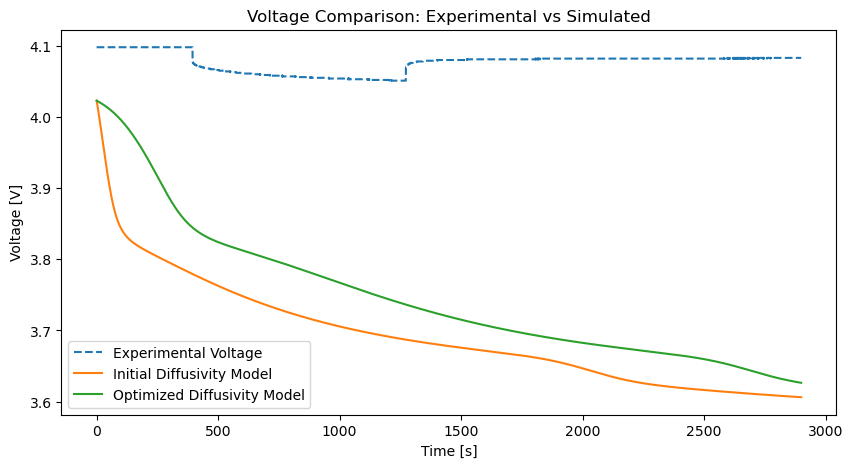

In [252]:
# Run optimization (Replace 'data.csv' with your actual CSV file)
if __name__ == "__main__":
    (
        time,
        voltage,
        sim_voltage_initial,
        sim_voltage_optimized,
        optimized_diffusivities,
    ) = optimize_diffusivity(file_path)
    # Plot comparison at the end
    plt.figure(figsize=(10, 5))
    plt.plot(time, voltage, label="Experimental Voltage", linestyle="dashed")
    plt.plot(time, sim_voltage_initial, label="Initial Diffusivity Model")
    plt.plot(time, sim_voltage_optimized, label="Optimized Diffusivity Model")
    plt.xlabel("Time [s]")
    plt.ylabel("Voltage [V]")
    plt.legend()
    plt.title("Voltage Comparison: Experimental vs Simulated")
    plt.show()

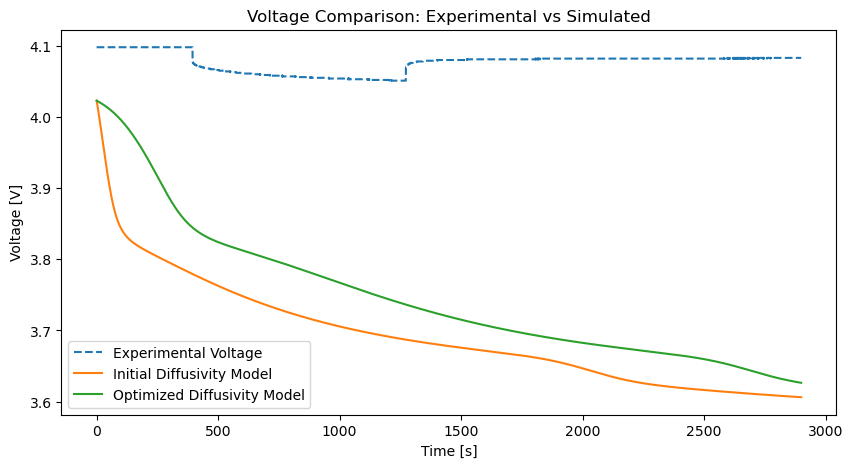

In [253]:
# Plot comparison at the end
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, label="Experimental Voltage", linestyle="dashed")
plt.plot(time, sim_voltage_initial, label="Initial Diffusivity Model")
plt.plot(time, sim_voltage_optimized, label="Optimized Diffusivity Model")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.title("Voltage Comparison: Experimental vs Simulated")
plt.show()